In [1]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

## Import Libraries

In [2]:
# Import required libraries
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [3]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [4]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
data_dir = 'dataset/cifar-10-python/cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [5]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (40000, 32, 32, 3)
Y_train shape:  (40000,)
Validation Set:
X_val shape:  (10000, 32, 32, 3)
Y_val shape:  (10000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
# datagen = ImageDataGenerator(
#         rotation_range=10, # rotation
#         width_shift_range=0.2, # horizontal shift
#         height_shift_range=0.2, # vertical shift
#         zoom_range=0.2, # zoom
#         horizontal_flip=True, # horizontal flip
#         # brightness_range=[0.2,1.0] # brightness
# )

# For purposes of creating a baseline, construct empty ImageDataGenerator
datagen = ImageDataGenerator()

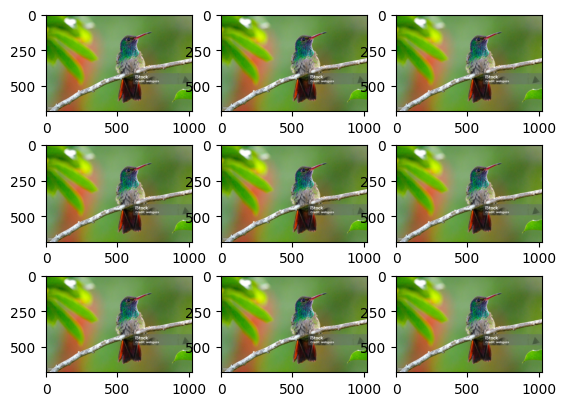

In [111]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-processing dataset

In [7]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [8]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()
    
def plot_multiple_accuracies(models, title):
    """
    Function to plot accuracy curves for both training and validation sets of multiple models at once.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['accuracy'], label='train_accuracy' + "_" + key)
        plt.plot(history.history['val_accuracy'], label='val_accuracy' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(new_title = title + " Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title = title + " Loss")
    plt.show()
    
def plot_multiple_losses(models, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['loss'], label='train_loss' + "_" + key)
        plt.plot(history.history['val_loss'], label='val_loss' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))
    return accuracy * 100
    
def save_plot(plt, name):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    filepath = "Graphs/" + name
    # if os.path.isfile(filepath):
    #     filepath += "_second"
    #     print("Same filename. Please alter the params_string. You will not get another warning before losing figures!!")
    plt.savefig(filepath)


In [9]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam'):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    res_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [17]:
# Build ResNet Model 1
resnet_model_1 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam')
resnet_model_1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 32, 32, 64)           1792      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_60 (Ba  (None, 32, 32, 64)           256       ['conv2d_60[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_54 (Activation)  (None, 32, 32, 64)           0         ['batch_normalization_60

In [18]:
# Build ResNet Model 2
resnet_model_2 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(5,5), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam')
resnet_model_2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 32, 32, 64)           4864      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_70 (Ba  (None, 32, 32, 64)           256       ['conv2d_70[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_63 (Activation)  (None, 32, 32, 64)           0         ['batch_normalization_70

In [20]:
# # Build ResNet Model 3
# resnet_model_3 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(7,7), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam')
# resnet_model_3.summary()

In [14]:
# # Build ResNet Model 4
# resnet_model_4 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD')
# resnet_model_4.summary()

TO DO:
1. keras callbacks: save checkpoint with best performance on validation data (rishie)
2. Add hyperparameter tuning as arguments (gio)
3. Save graphs under different names (gio)
4. ImageDataGenerator - read about this to add augmentation (rishie)
5. Regularization - Dropouts in random/hyperparameter
6. Loading custom data (rishie)

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Title of the Hypothesis Tested
title = "Varying Conv Kernel Size"

# These are used to distinguish the models from each other
param_1 = "(3x3)"
param_2 = "(5x5)"
# param_3 = "Three Blocks Per Layer"
# param_4 = "Four Blocks Per Layer"

checkpoint_filepath_1 = 'ckpt/' + title + '/' + param_1
checkpoint_filepath_2 = 'ckpt/' + title + '/' + param_2 
# checkpoint_filepath_3 = 'ckpt/' + title + '/' + param_3
# checkpoint_filepath_4 = 'ckpt/' + title + '/' + param_4

# Defining callback
model_checkpoint_callback_1 = ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_2 = ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# model_checkpoint_callback_3 = ModelCheckpoint(
#     filepath=checkpoint_filepath_3,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# model_checkpoint_callback_4 = ModelCheckpoint(
#     filepath=checkpoint_filepath_4,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [22]:
# Augmenting on the fly with datagen.flow()
batch_size=64
epochs=30

# For running multiple networks at the same time, create dictionary to store history values and lists to store all other info
histories = {}
keys = [param_1, param_2] #, param_3, param_4]
models = [resnet_model_1, resnet_model_2] #, resnet_model_3, resnet_model_4]
checkpoints = [model_checkpoint_callback_1, model_checkpoint_callback_2] #, model_checkpoint_callback_3, model_checkpoint_callback_4]
# Explain whats happening here!!!
for i in range(len(models)):
# Directly use .flow() to load our dataset in batches for training
    histories[keys[i]] = models[i].fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                    epochs = epochs, # set number of epochs
                                    steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                    validation_data = (X_val, Y_val), # data for validation
                                    callbacks=[checkpoints[i]], # model checkpoint
                                    verbose=1)

Epoch 1/30


2024-04-11 22:58:26.674982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 1.5463 - accuracy: 0.4439

2024-04-11 22:59:01.703223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 39s 58ms/step - loss: 1.5463 - accuracy: 0.4439 - val_loss: 24.6755 - val_accuracy: 0.1121
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.7526 - accuracy: 0.3767INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 36s 58ms/step - loss: 1.7526 - accuracy: 0.3767 - val_loss: 1.5491 - val_accuracy: 0.4486
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.4593 - accuracy: 0.4788INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 35s 56ms/step - loss: 1.4593 - accuracy: 0.4788 - val_loss: 1.3824 - val_accuracy: 0.4965
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 1.2965 - accuracy: 0.5389INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 34s 55ms/step - loss: 1.2965 - accuracy: 0.5389 - val_loss: 1.2178 - val_accuracy: 0.5679
Epoch 5/30
624/625 [============================>.] - ETA: 0s - loss: 1.1612 - accuracy: 0.5863INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 34s 55ms/step - loss: 1.1614 - accuracy: 0.5862 - val_loss: 1.1237 - val_accuracy: 0.6025
Epoch 6/30
624/625 [============================>.] - ETA: 0s - loss: 1.0571 - accuracy: 0.6269INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 34s 55ms/step - loss: 1.0571 - accuracy: 0.6268 - val_loss: 1.0611 - val_accuracy: 0.6240
Epoch 7/30
625/625 [==============================] - ETA: 0s - loss: 0.9690 - accuracy: 0.6617INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 34s 55ms/step - loss: 0.9690 - accuracy: 0.6617 - val_loss: 1.0084 - val_accuracy: 0.6484
Epoch 8/30
624/625 [============================>.] - ETA: 0s - loss: 0.8937 - accuracy: 0.6866INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 34s 55ms/step - loss: 0.8935 - accuracy: 0.6866 - val_loss: 0.9083 - val_accuracy: 0.6789
Epoch 9/30
625/625 [==============================] - 33s 53ms/step - loss: 0.8191 - accuracy: 0.7130 - val_loss: 1.0300 - val_accuracy: 0.6489
Epoch 10/30
625/625 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.7352INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 34s 55ms/step - loss: 0.7527 - accuracy: 0.7352 - val_loss: 0.8655 - val_accuracy: 0.7064
Epoch 11/30
624/625 [============================>.] - ETA: 0s - loss: 0.6964 - accuracy: 0.7560INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(3x3)/assets


625/625 [==============================] - 34s 55ms/step - loss: 0.6963 - accuracy: 0.7560 - val_loss: 0.8145 - val_accuracy: 0.7180
Epoch 12/30
625/625 [==============================] - 34s 55ms/step - loss: 1.2388 - accuracy: 0.5631 - val_loss: 1.5276 - val_accuracy: 0.4522
Epoch 13/30
625/625 [==============================] - 33s 53ms/step - loss: 1.3320 - accuracy: 0.5245 - val_loss: 1.2411 - val_accuracy: 0.5626
Epoch 14/30
625/625 [==============================] - 36s 57ms/step - loss: 1.1012 - accuracy: 0.6116 - val_loss: 1.0258 - val_accuracy: 0.6400
Epoch 15/30
625/625 [==============================] - 36s 58ms/step - loss: 0.9463 - accuracy: 0.6708 - val_loss: 0.9949 - val_accuracy: 0.6572
Epoch 16/30
625/625 [==============================] - 36s 58ms/step - loss: 0.8457 - accuracy: 0.7044 - val_loss: 0.9164 - val_accuracy: 0.6801
Epoch 17/30
625/625 [==============================] - 36s 57ms/step - loss: 0.7687 - accuracy: 0.7321 - val_loss: 0.9468 - val_accuracy: 0.67

2024-04-11 23:15:52.806693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 1.2889 - accuracy: 0.5391

2024-04-11 23:16:58.980539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 73s 116ms/step - loss: 1.2889 - accuracy: 0.5391 - val_loss: 1.3180 - val_accuracy: 0.5377
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 0.8313 - accuracy: 0.7092INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 73s 117ms/step - loss: 0.8313 - accuracy: 0.7092 - val_loss: 1.1283 - val_accuracy: 0.6259
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.7720INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 74s 119ms/step - loss: 0.6523 - accuracy: 0.7720 - val_loss: 0.8360 - val_accuracy: 0.7210
Epoch 4/30
625/625 [==============================] - 73s 117ms/step - loss: 0.5402 - accuracy: 0.8144 - val_loss: 1.0012 - val_accuracy: 0.6960
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.8441INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 74s 118ms/step - loss: 0.4508 - accuracy: 0.8441 - val_loss: 0.7609 - val_accuracy: 0.7523
Epoch 6/30
625/625 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8708INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 74s 119ms/step - loss: 0.3781 - accuracy: 0.8708 - val_loss: 0.6279 - val_accuracy: 0.7803
Epoch 7/30
625/625 [==============================] - 73s 117ms/step - loss: 0.3069 - accuracy: 0.8944 - val_loss: 1.0028 - val_accuracy: 0.7026
Epoch 8/30
625/625 [==============================] - 73s 117ms/step - loss: 0.2557 - accuracy: 0.9109 - val_loss: 0.7400 - val_accuracy: 0.7781
Epoch 9/30
625/625 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9299INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 74s 119ms/step - loss: 0.2027 - accuracy: 0.9299 - val_loss: 0.5972 - val_accuracy: 0.8043
Epoch 10/30
625/625 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9433INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 74s 118ms/step - loss: 0.1642 - accuracy: 0.9433 - val_loss: 0.6427 - val_accuracy: 0.8056
Epoch 11/30
625/625 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9591INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 74s 119ms/step - loss: 0.1222 - accuracy: 0.9591 - val_loss: 0.7056 - val_accuracy: 0.8059
Epoch 12/30
625/625 [==============================] - 73s 117ms/step - loss: 0.0943 - accuracy: 0.9683 - val_loss: 0.9035 - val_accuracy: 0.7780
Epoch 13/30
625/625 [==============================] - 73s 117ms/step - loss: 0.0866 - accuracy: 0.9704 - val_loss: 1.2901 - val_accuracy: 0.6369
Epoch 14/30
625/625 [==============================] - 73s 116ms/step - loss: 1.0565 - accuracy: 0.6432 - val_loss: 0.8366 - val_accuracy: 0.7166
Epoch 15/30
625/625 [==============================] - 1100s 2s/step - loss: 0.5212 - accuracy: 0.8202 - val_loss: 0.6439 - val_accuracy: 0.7823
Epoch 16/30
625/625 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.8824INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 73s 117ms/step - loss: 0.3448 - accuracy: 0.8824 - val_loss: 0.5672 - val_accuracy: 0.8148
Epoch 17/30
625/625 [==============================] - 72s 114ms/step - loss: 0.2350 - accuracy: 0.9222 - val_loss: 0.6018 - val_accuracy: 0.8124
Epoch 18/30
625/625 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9520INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 72s 116ms/step - loss: 0.1523 - accuracy: 0.9520 - val_loss: 0.5597 - val_accuracy: 0.8261
Epoch 19/30
625/625 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9714INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 72s 115ms/step - loss: 0.0974 - accuracy: 0.9714 - val_loss: 0.5674 - val_accuracy: 0.8382
Epoch 20/30
625/625 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9850INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


INFO:tensorflow:Assets written to: ckpt/Varying Conv Kernel Size/(5x5)/assets


625/625 [==============================] - 72s 115ms/step - loss: 0.0606 - accuracy: 0.9850 - val_loss: 0.5795 - val_accuracy: 0.8436
Epoch 21/30
625/625 [==============================] - 71s 114ms/step - loss: 0.0397 - accuracy: 0.9918 - val_loss: 0.7109 - val_accuracy: 0.8300
Epoch 22/30
625/625 [==============================] - 73s 117ms/step - loss: 0.0318 - accuracy: 0.9929 - val_loss: 0.7075 - val_accuracy: 0.8324
Epoch 23/30
625/625 [==============================] - 73s 117ms/step - loss: 0.0425 - accuracy: 0.9877 - val_loss: 0.9475 - val_accuracy: 0.7976
Epoch 24/30
625/625 [==============================] - 73s 117ms/step - loss: 0.0549 - accuracy: 0.9815 - val_loss: 0.9563 - val_accuracy: 0.8078
Epoch 25/30
625/625 [==============================] - 73s 117ms/step - loss: 0.0449 - accuracy: 0.9857 - val_loss: 1.0563 - val_accuracy: 0.7876
Epoch 26/30
625/625 [==============================] - 73s 117ms/step - loss: 0.0450 - accuracy: 0.9848 - val_loss: 0.8099 - val_accurac

In [ ]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


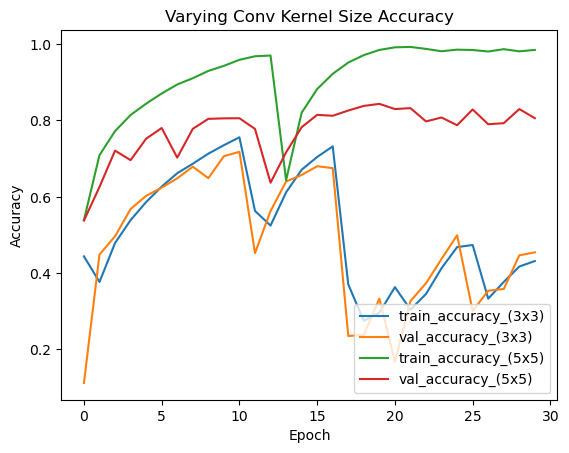

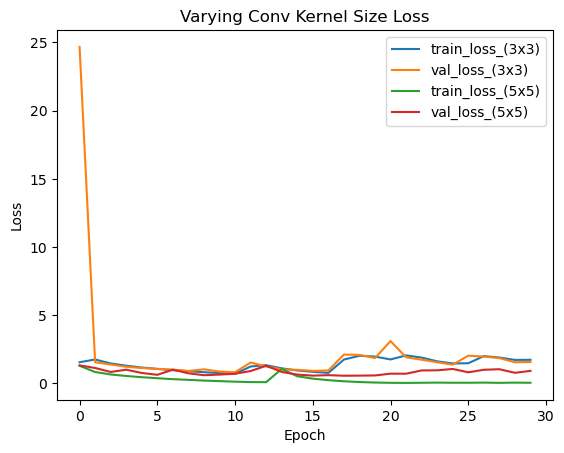

In [23]:
# Plot accuracy and loss
# accuracy_title = title + ' Accuracy'
# loss_title = title + ' Loss'
# plot_accuracy(resnet_history, accuracy_title)
# plot_loss(resnet_history, loss_title)

# Plot all models' accuracies and losses on the same graph:
plot_multiple_accuracies(histories, title)
plot_multiple_losses(histories, title)

In [24]:
# Load the model with the maximum validation accuracy from checkpoint on disk
test_model_1 = tf.keras.models.load_model(checkpoint_filepath_1)
test_model_2 = tf.keras.models.load_model(checkpoint_filepath_2)
# test_model_3 = tf.keras.models.load_model(checkpoint_filepath_3)
# test_model_4 = tf.keras.models.load_model(checkpoint_filepath_4)

In [25]:
# Evaluate test set using best version of each model and save outputs to a file
print(title + ':')
accuracy_list = []
for i in range(len(models)):
    accuracy_list.append(evaluate_model(models[i], X_test, Y_test))

with open("Test_Accuracy.txt", 'a') as file:
    file_title = title + ':\n'
    file.write(file_title)
    for i in range(len(accuracy_list)):
        acc_string = str(keys[i]) + '\t' + str(accuracy_list[i]) + '\n'
        file.write(acc_string)
    file.write('\n')

Varying Conv Kernel Size:
Test Accuracy: 46.07%
Test Accuracy: 81.02%


In [26]:
from playsound import playsound
playsound("GOT TO GO.mp3")
playsound("GOT TO GO.mp3")
playsound("GOT TO GO.mp3")

ModuleNotFoundError: No module named 'playsound'

In [ ]:
# Extra setup for loading specific models and evaluating
# test_model = tf.keras.models.load_model("ckpt\Baseline ResNet Model\Baseline")
# evaluate_model(test_model, X_test, Y_test)